# SELECTION OF STORMS THRESHOLDS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy
import utils
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

sym_asy = pd.read_pickle('./sym_asy_indices.pkl', compression = 'gzip')

In [2]:
print(f'Evaluated period for the SYM and ASY indices --> from {sym_asy.index[0]} until {sym_asy.index[-1]}')
tdf = sym_asy.index[1] - sym_asy.index[0]
print(f'Evaluated resolution: {tdf.seconds // 60} minutes')
print(f'Total of {len(sym_asy)} values for each index')

na_values = sym_asy.isna().sum().sum()
if na_values == 0:
    print('No missing values')
else:
    print(f'There are {na_values} missing values')

Evaluated period for the SYM and ASY indices --> from 1981-01-01 00:00:00 until 2023-01-01 00:00:00
Evaluated resolution: 5 minutes
Total of 4417921 values for each index
No missing values


### Plot of the raw data

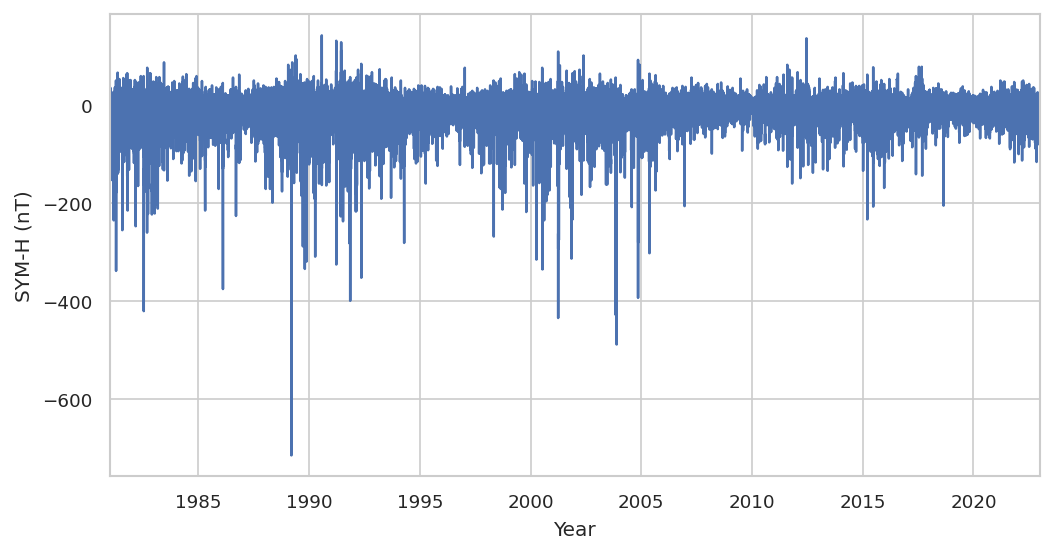

In [3]:
ax = sym_asy['SYM_H'].plot(xlabel = 'Year', ylabel = 'SYM-H (nT)', figsize = utils.global_figsize);

### Autocorrelation analysis over the base series

Autocorrelation for the base SYM-H index time series 1 lags: 0.998
Autocorrelation for the base SYM-H index time series 2 lags: 0.994
Autocorrelation for the base SYM-H index time series 3 lags: 0.990
Autocorrelation for the base SYM-H index time series 4 lags: 0.987
Autocorrelation for the base SYM-H index time series 5 lags: 0.983
Autocorrelation for the base SYM-H index time series 6 lags: 0.979
Autocorrelation for the base SYM-H index time series 7 lags: 0.975
Autocorrelation for the base SYM-H index time series 8 lags: 0.972
Autocorrelation for the base SYM-H index time series 9 lags: 0.968
Autocorrelation for the base SYM-H index time series 10 lags: 0.964


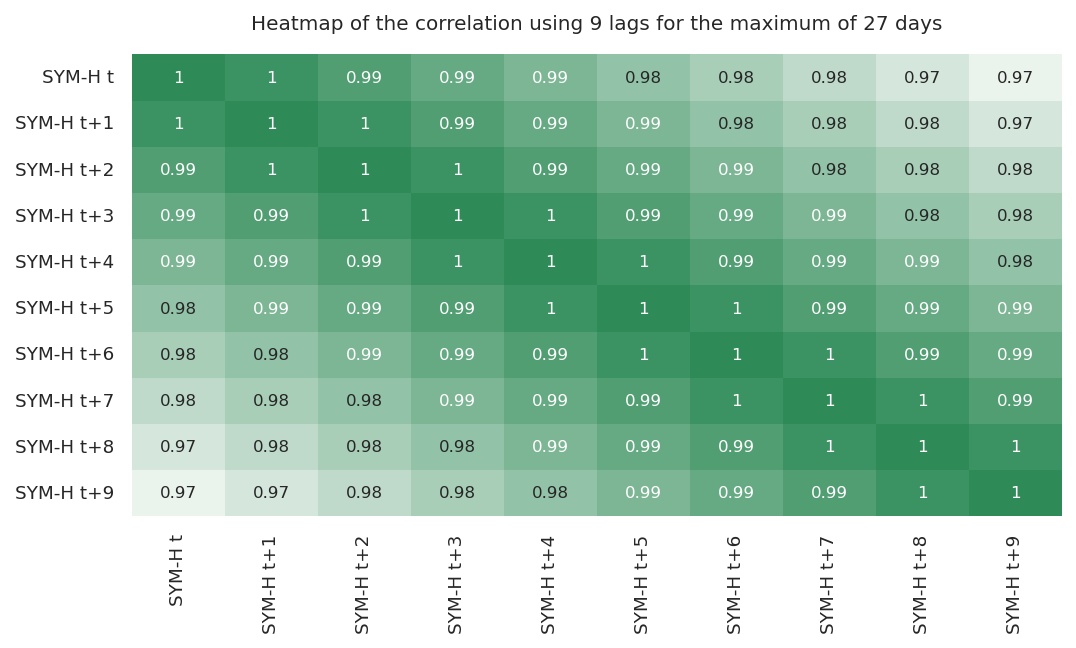

In [4]:
lags = np.arange(1, 10)
df_sym_corr = sym_asy['SYM_H'].copy()
concats = [df_sym_corr]
cols = ['SYM-H t']
for l in lags:
    concats.append(df_sym_corr.shift(l))
    cols.append(f'SYM-H t+{l}')
    

df_sym_corr = pd.concat(concats, axis = 1)
df_sym_corr.columns = cols
result = df_sym_corr.corr()

fig, ax = plt.subplots(1, figsize = utils.global_figsize)

sns.heatmap(result, annot=True, annot_kws={"size": 8}, ax = ax, cbar = False, 
            cmap = sns.light_palette("seagreen", as_cmap=True));
ax.set_title('Heatmap of the correlation using 9 lags for the maximum of 27 days', pad = 12);

for i in range(10):    
    print(f'Autocorrelation for the base SYM-H index time series {i + 1} lags: {sym_asy["SYM_H"].autocorr(lag = i + 1):.3f}')

del df_sym_corr
    
plt.show();

### Plot of the resampled data

We have a total of 569 values


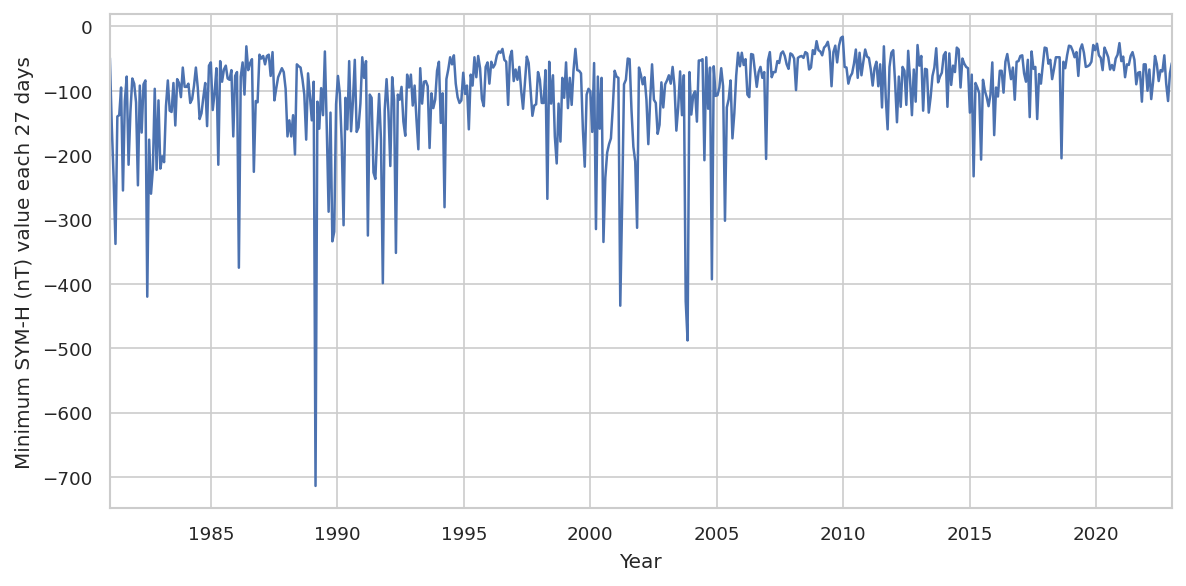

In [5]:
sym_resampled = sym_asy['SYM_H'].resample("27d").min()
print(f'We have a total of {len(sym_resampled)} values')
sym_resampled.plot(xlabel = 'Year', ylabel = 'Minimum SYM-H (nT) value each 27 days', figsize = utils.global_figsize);
plt.tight_layout();
plt.savefig('./figs/sym-resampled.png')

### Autocorrelation analysis of the resampled data

Autocorrelation for the resampled SYM-H index time series 1 lags: 0.272
Autocorrelation for the resampled SYM-H index time series 2 lags: 0.230
Autocorrelation for the resampled SYM-H index time series 3 lags: 0.176
Autocorrelation for the resampled SYM-H index time series 4 lags: 0.201
Autocorrelation for the resampled SYM-H index time series 5 lags: 0.226
Autocorrelation for the resampled SYM-H index time series 6 lags: 0.210
Autocorrelation for the resampled SYM-H index time series 7 lags: 0.275
Autocorrelation for the resampled SYM-H index time series 8 lags: 0.263
Autocorrelation for the resampled SYM-H index time series 9 lags: 0.246
Autocorrelation for the resampled SYM-H index time series 10 lags: 0.134


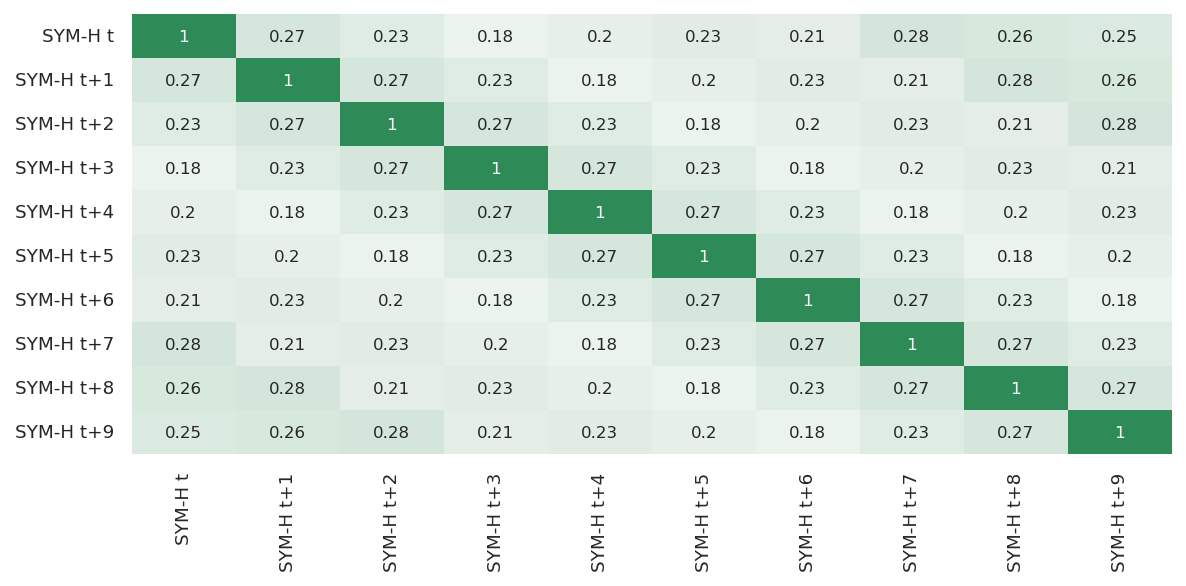

In [6]:
lags = np.arange(1, 10)
df_sym_corr = sym_resampled.copy()
concats = [df_sym_corr]
cols = ['SYM-H t']
for l in lags:
    concats.append(df_sym_corr.shift(l))
    cols.append(f'SYM-H t+{l}')
    

df_sym_corr = pd.concat(concats, axis = 1)
df_sym_corr.columns = cols
result = df_sym_corr.corr()

fig, ax = plt.subplots(1, figsize = utils.global_figsize)

sns.heatmap(result, annot=True, annot_kws={"size": 8}, ax = ax, cbar = False, 
            cmap = sns.light_palette("seagreen", as_cmap=True));
plt.tight_layout();
plt.savefig('./figs/sym-heatmap.png')

for i in range(10):
    print(f'Autocorrelation for the resampled SYM-H index time series {i + 1} lags: {sym_resampled.autocorr(lag = i + 1):.3f}')

plt.show();

### CDF with the percentile threshold

Selected percentiles are 0.01, 0.05, 0.2 and 0.4

Magenta line on quantile 1: -395 nT rounded: -390
Red line on quantile 5: -231 nT rounded: -230
Orange dashed line on quantile 20: -130 nT rounded: -130
Yellow dashed line on quantile 40: -92 nT rounded: -90


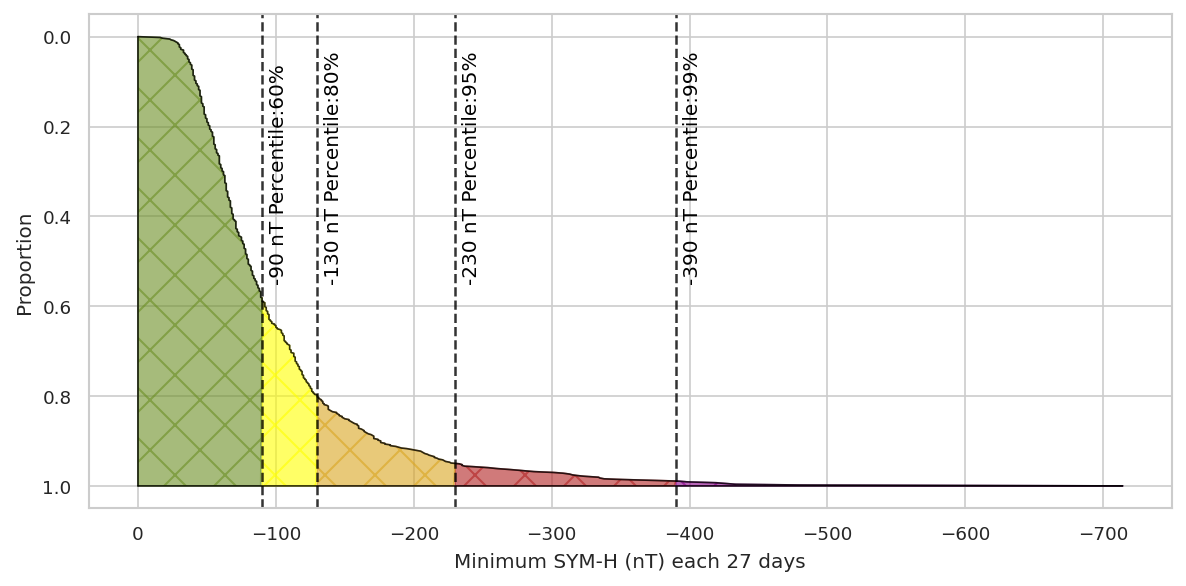

In [7]:
fig, ax = plt.subplots(figsize = utils.global_figsize)
dat = sym_resampled.values
x = np.sort(dat)
y = np.arange(len(x)) / float(len(x))

cdf_plot = pd.DataFrame(data = np.array([x, y]).T, columns = ['value', 'cdf'])
cdf_interp = pd.DataFrame(data = np.arange(cdf_plot['value'].values[0], cdf_plot['value'].values[-1] + 1), columns = ['value'] )
cdf_plot = cdf_plot.set_index('value')
cdf_interp['cdf'] = np.nan
cdf_interp = cdf_interp.set_index('value')
cdf_interp = cdf_interp.combine_first(cdf_plot)
cdf_interp = cdf_interp.interpolate()
cdf_interp.loc[0] = 1

dfmins = pd.DataFrame(columns = ['SYM_H', 'CDF'])
dfmins['SYM_H'] = x
dfmins['CDF'] = y
dfmins = dfmins.dropna()

q0 = 0.01
q0_val = np.around(dfmins.quantile(q0)['SYM_H'], -1)
q1 = 0.05
q1_val = np.around(dfmins.quantile(q1)['SYM_H'], -1)
q2 = 0.2
q2_val = np.around(dfmins.quantile(q2)['SYM_H'], -1)
q3 = 0.4
q3_val = np.around(dfmins.quantile(q3)['SYM_H'], -1)

ax.plot(cdf_interp.index, cdf_interp['cdf'].values, color = 'black', linewidth = 0.8, alpha = 0.8);
ax.plot(cdf_interp.index, np.zeros_like(cdf_interp.index), color = 'black', linewidth = 0.8, alpha = 0.8);
ax.plot(np.zeros_like(cdf_interp.index), cdf_interp['cdf'].values, color = 'black', linewidth = 0.8, alpha = 0.8);

ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= cdf_interp.index <= q0_val, interpolate=True, color=utils.COLOR_SUPERINTENSE, alpha = 0.6, hatch='x')
ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= np.logical_and(cdf_interp.index > q0_val, cdf_interp.index <= q1_val), interpolate=True, color=utils.COLOR_INTENSE, alpha = 0.6, hatch='x')
ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= np.logical_and(cdf_interp.index > q1_val, cdf_interp.index <= q2_val), interpolate=True, color=utils.COLOR_MODERATE, alpha = 0.6, hatch='x')
ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= np.logical_and(cdf_interp.index > q2_val, cdf_interp.index <= q3_val), interpolate=True, color=utils.COLOR_LOW, alpha = 0.6, hatch='x')
ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= cdf_interp.index > q3_val, interpolate=True, color=utils.COLOR_INACTIVE, alpha = 0.6, hatch='x')

for qi, qval in zip([q0, q1, q2, q3], [q0_val, q1_val, q2_val, q3_val]):

    ax.axvline(qval, color = 'black', linestyle = '--', alpha = 0.8)
    ax.text(qval - 5, 0.45 , f'{qval:.0f} nT Percentile:{(1-qi)*100:.0f}%', color = 'black', alpha = 1, rotation = 90, horizontalalignment='left', verticalalignment = 'bottom')

print(f"Magenta line on quantile {q0*100:.0f}: {dfmins.quantile(q0)['SYM_H']:.0f} nT rounded: {np.around(dfmins.quantile(q0)['SYM_H'], -1):.0f}")
print(f"Red line on quantile {q1*100:.0f}: {dfmins.quantile(q1)['SYM_H']:.0f} nT rounded: {np.around(dfmins.quantile(q1)['SYM_H'], -1):.0f}")
print(f"Orange dashed line on quantile {q2*100:.0f}: {dfmins.quantile(q2)['SYM_H']:.0f} nT rounded: {np.around(dfmins.quantile(q2)['SYM_H'], -1):.0f}")
print(f"Yellow dashed line on quantile {q3*100:.0f}: {dfmins.quantile(q3)['SYM_H']:.0f} nT rounded: {np.around(dfmins.quantile(q3)['SYM_H'], -1):.0f}")

ax.set_xlabel('Minimum SYM-H (nT) each 27 days')
ax.set_ylabel('Proportion');

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['1.0', '0.8', '0.6', '0.4', '0.2', '0.0'])

plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig('figs/sym-distribution.png')
plt.show();

In [8]:
SYM_H_THRESHOLD_LOW = -90
SYM_H_THRESHOLD_MODERATE = -130
SYM_H_THRESHOLD_INTENSE = -230
SYM_H_THRESHOLD_SUPERINTENSE = -390

print('Number of values in superintense',len(sym_resampled[sym_resampled <= SYM_H_THRESHOLD_SUPERINTENSE]))
print('Number of values in intense',len(sym_resampled[(sym_resampled <= SYM_H_THRESHOLD_INTENSE) & (sym_resampled > SYM_H_THRESHOLD_SUPERINTENSE)]))
print('Number of values in moderate',len(sym_resampled[(sym_resampled <= SYM_H_THRESHOLD_MODERATE) & (sym_resampled > SYM_H_THRESHOLD_INTENSE)]))
print('Number of values in low',len(sym_resampled[(sym_resampled <= SYM_H_THRESHOLD_LOW) & (sym_resampled > SYM_H_THRESHOLD_MODERATE)]))

sym_intense_super = sym_resampled[sym_resampled <= SYM_H_THRESHOLD_INTENSE].copy()
print(f'Count of values above moderate: {len(sym_intense_super)} Mean of the maximum SYM-H: {sym_intense_super.mean():.0f} std: {sym_intense_super.std():.2f} Median of the maximum SYM-H: {sym_intense_super.median():.0f}')

sym_intense = sym_resampled[(sym_resampled <= SYM_H_THRESHOLD_INTENSE) & (sym_resampled > SYM_H_THRESHOLD_SUPERINTENSE)].copy()
print(f'Count of intense values: {len(sym_intense)} Mean of the maximum SYM-H: {sym_intense.mean():.0f} std: {sym_intense.std():.2f} Median of the maximum SYM-H: {sym_intense.median():.0f}')

sym_super = sym_resampled[sym_resampled <= SYM_H_THRESHOLD_SUPERINTENSE].copy()
print(f'Count of superintense values: {len(sym_super)} Mean of the maximum SYM-H of the superintense: {sym_super.mean():.0f} std: {sym_super.std():.2f} Median of the maximum SYM-H: {sym_super.median():.0f}')

sym_moderate = sym_resampled[(sym_resampled <= SYM_H_THRESHOLD_MODERATE) & (sym_resampled > SYM_H_THRESHOLD_INTENSE)].copy()
print(f'Count of moderate values: {len(sym_moderate)} Mean of the maximum SYM-H: {sym_moderate.mean():.0f} std: {sym_moderate.std():.2f} Median of the maximum SYM-H: {sym_moderate.median():.0f}')

sym_low = sym_resampled[(sym_resampled <= SYM_H_THRESHOLD_MODERATE) & (sym_resampled > SYM_H_THRESHOLD_INTENSE)].copy()
print(f'Count of low values: {len(sym_low)} Mean of the maximum SYM-H: {sym_low.mean():.0f} std: {sym_low.std():.2f} Median of the maximum SYM-H: {sym_low.median():.0f}')

print(f'Global stats: {len(sym_resampled)} Mean of the maximum SYM-H: {sym_resampled.mean():.0f} std: {sym_resampled.std():.2f} Median of the maximum SYM-H: {sym_resampled.median():.0f}')

Number of values in superintense 7
Number of values in intense 22
Number of values in moderate 87
Number of values in low 123
Count of values above moderate: 29 Mean of the maximum SYM-H: -335 std: 99.62 Median of the maximum SYM-H: -315
Count of intense values: 22 Mean of the maximum SYM-H: -292 std: 42.44 Median of the maximum SYM-H: -295
Count of superintense values: 7 Mean of the maximum SYM-H of the superintense: -468 std: 112.87 Median of the maximum SYM-H: -427
Count of moderate values: 87 Mean of the maximum SYM-H: -167 std: 28.87 Median of the maximum SYM-H: -162
Count of low values: 87 Mean of the maximum SYM-H: -167 std: 28.87 Median of the maximum SYM-H: -162
Global stats: 569 Mean of the maximum SYM-H: -101 std: 72.58 Median of the maximum SYM-H: -80


# Selection ASY-H

## Plot of the raw data

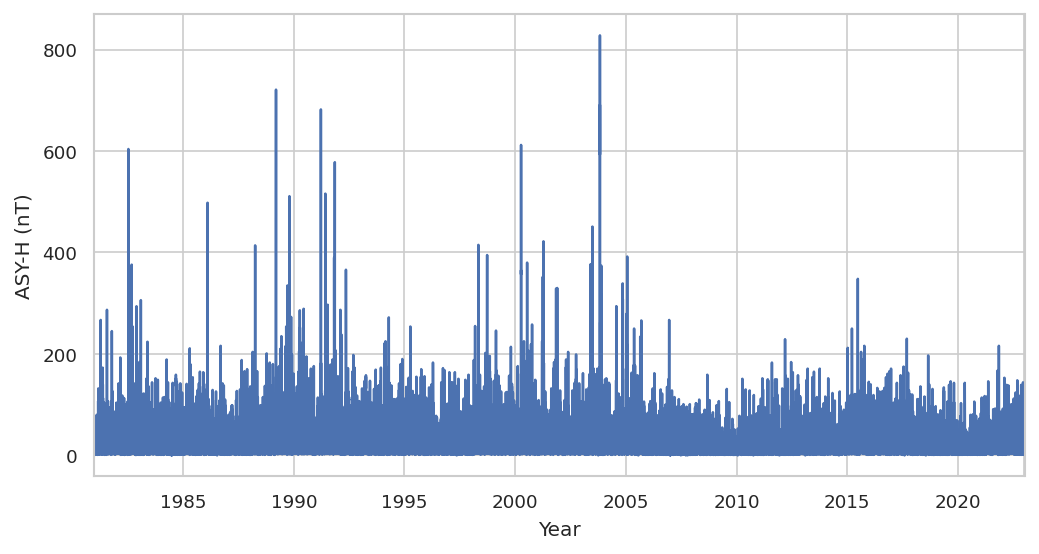

In [9]:
sym_asy['ASY_H'].plot(xlabel = 'Year', ylabel = 'ASY-H (nT)', figsize = utils.global_figsize);

### Autocorrelation analysis over the base series

Autocorrelation for the base ASY-H index time series 1 lags: 0.987
Autocorrelation for the base ASY-H index time series 2 lags: 0.964
Autocorrelation for the base ASY-H index time series 3 lags: 0.941
Autocorrelation for the base ASY-H index time series 4 lags: 0.917
Autocorrelation for the base ASY-H index time series 5 lags: 0.895
Autocorrelation for the base ASY-H index time series 6 lags: 0.873
Autocorrelation for the base ASY-H index time series 7 lags: 0.853
Autocorrelation for the base ASY-H index time series 8 lags: 0.834
Autocorrelation for the base ASY-H index time series 9 lags: 0.817
Autocorrelation for the base ASY-H index time series 10 lags: 0.800


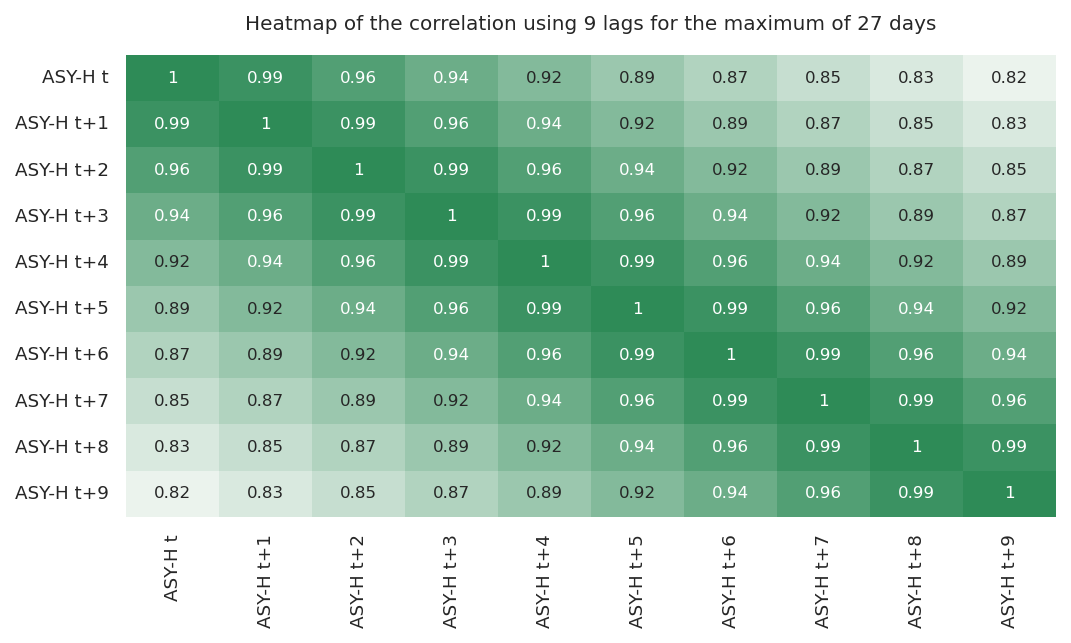

In [10]:
lags = np.arange(1, 10)
df_asy_corr = sym_asy['ASY_H'].copy()
concats = [df_asy_corr]
cols = ['ASY-H t']
for l in lags:
    concats.append(df_asy_corr.shift(l))
    cols.append(f'ASY-H t+{l}')
    

df_asy_corr = pd.concat(concats, axis = 1)
df_asy_corr.columns = cols
result = df_asy_corr.corr()

fig, ax = plt.subplots(1, figsize = utils.global_figsize)

sns.heatmap(result, annot=True, annot_kws={"size": 8}, ax = ax, cbar = False, 
            cmap = sns.light_palette("seagreen", as_cmap=True));
ax.set_title('Heatmap of the correlation using 9 lags for the maximum of 27 days', pad = 12);

for i in range(10):    
    print(f'Autocorrelation for the base ASY-H index time series {i + 1} lags: {sym_asy["ASY_H"].autocorr(lag = i + 1):.3f}')

del df_asy_corr
    
plt.show();

Select the maximum of each 27 days to avoid the persistence of the coronal holes

### Plot of the resampled data

We have a total of 569 values


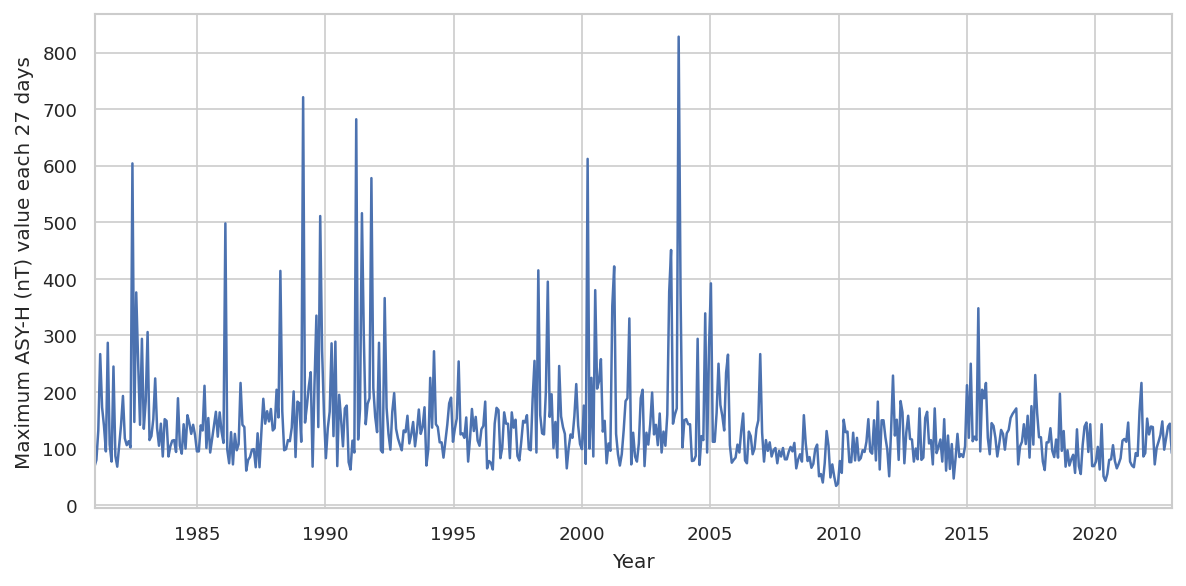

In [11]:
asy_resampled = sym_asy['ASY_H'].resample("27d").max()
print(f'We have a total of {len(asy_resampled)} values')
asy_resampled.plot(xlabel = 'Year', ylabel = 'Maximum ASY-H (nT) value each 27 days', figsize = utils.global_figsize);
plt.tight_layout();
plt.savefig('./figs/asy-resampled.png')

### Autocorrelation analysis

Autocorrelation for the resampled ASY-H index time series 1 lags: 0.162
Autocorrelation for the resampled ASY-H index time series 2 lags: 0.144
Autocorrelation for the resampled ASY-H index time series 3 lags: 0.126
Autocorrelation for the resampled ASY-H index time series 4 lags: 0.173
Autocorrelation for the resampled ASY-H index time series 5 lags: 0.194
Autocorrelation for the resampled ASY-H index time series 6 lags: 0.138
Autocorrelation for the resampled ASY-H index time series 7 lags: 0.139
Autocorrelation for the resampled ASY-H index time series 8 lags: 0.136
Autocorrelation for the resampled ASY-H index time series 9 lags: 0.126
Autocorrelation for the resampled ASY-H index time series 10 lags: 0.046


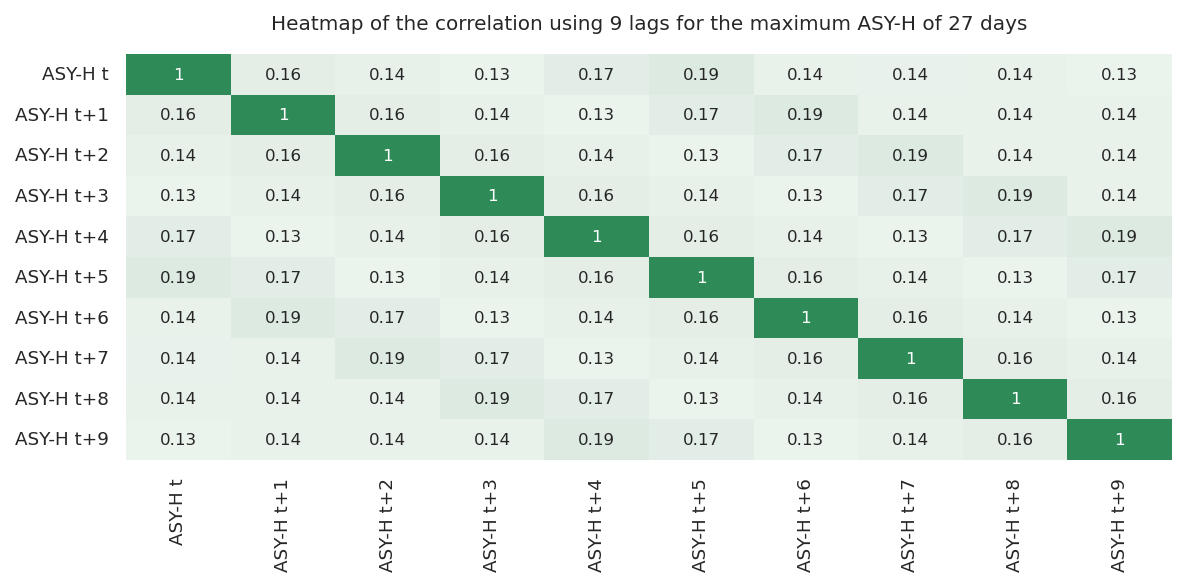

In [12]:
lags = np.arange(1, 10)
df_asy_corr = asy_resampled.copy()
concats = [df_asy_corr]
cols = ['ASY-H t']
for l in lags:
    concats.append(df_asy_corr.shift(l))
    cols.append(f'ASY-H t+{l}')    

df_asy_corr = pd.concat(concats, axis = 1)
df_asy_corr.columns = cols
result = df_asy_corr.corr()

fig, ax = plt.subplots(1, figsize = utils.global_figsize)

sns.heatmap(result, annot=True, annot_kws={"size": 8}, ax = ax, cbar = False, 
            cmap = sns.light_palette("seagreen", as_cmap=True));
ax.set_title('Heatmap of the correlation using 9 lags for the maximum ASY-H of 27 days', pad = 12);

for i in range(10):    
    print(f'Autocorrelation for the resampled ASY-H index time series {i + 1} lags: {asy_resampled.autocorr(lag = i + 1):.3f}')

plt.tight_layout();
plt.savefig('./figs/asy-heatmap.png')
plt.show();

### CDF with the percentile threshold

Selected percentiles are 0.99, 0.95, 0.8 and 0.6

Magenta line on quantile 99: 536 nT rounded: 540
Red line on quantile 95: 292 nT rounded: 290
Orange dashed line on quantile 80: 166 nT rounded: 170
Yellow dashed line on quantile 60: 135 nT rounded: 130


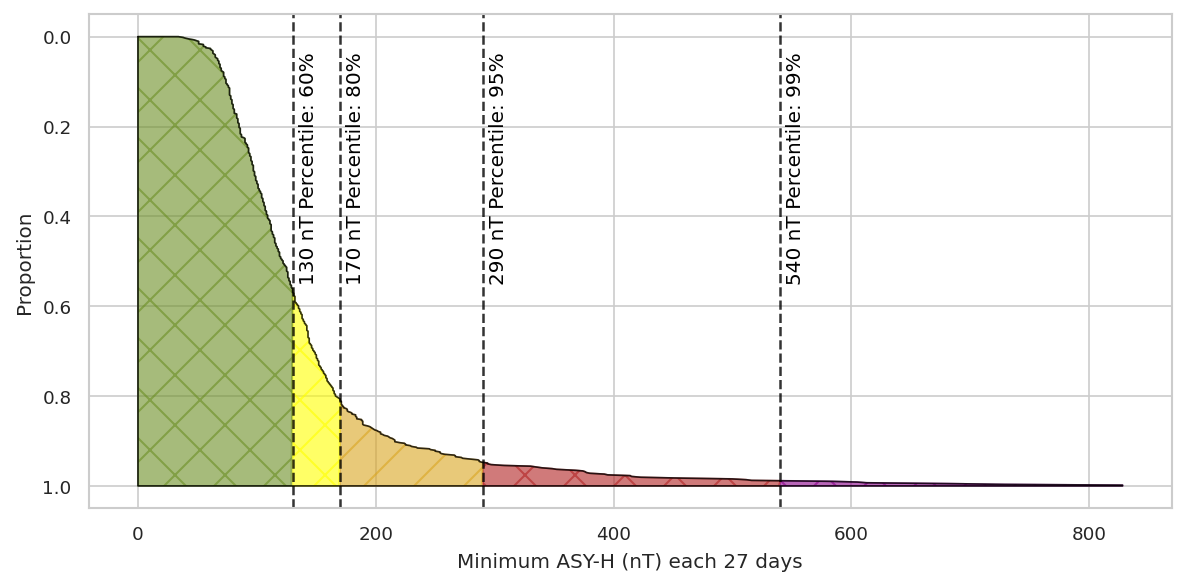

In [13]:
fig, ax = plt.subplots(figsize = utils.global_figsize)
dat = asy_resampled.values
x = np.sort(dat)
y = np.arange(len(x)) / float(len(x))
y = 1 - y

cdf_plot = pd.DataFrame(data = np.array([x, y]).T, columns = ['value', 'cdf'])
cdf_interp = pd.DataFrame(data = np.arange(cdf_plot['value'].values[0], cdf_plot['value'].values[-1] + 1), columns = ['value'] )
cdf_plot = cdf_plot.set_index('value')
cdf_interp['cdf'] = np.nan
cdf_interp = cdf_interp.set_index('value')
cdf_interp = cdf_interp.combine_first(cdf_plot)
cdf_interp = cdf_interp.interpolate()
cdf_interp = pd.concat([pd.DataFrame(index = [0], data = [1], columns = ['cdf']), cdf_interp])

dfmaxs = pd.DataFrame(columns = ['ASY_H', 'CDF'])
dfmaxs['ASY_H'] = x
dfmaxs['CDF'] = y
dfmaxs = dfmaxs.dropna()

q0 = 0.99
q0_val = np.around(dfmaxs.quantile(q0)['ASY_H'], -1)
q1 = 0.95
q1_val = np.around(dfmaxs.quantile(q1)['ASY_H'], -1)
q2 = 0.8
q2_val = np.around(dfmaxs.quantile(q2)['ASY_H'], -1)
q3 = 0.6
q3_val = np.around(dfmaxs.quantile(q3)['ASY_H'], -1)

ax.plot(cdf_interp.index, cdf_interp['cdf'].values, color = 'black', linewidth = 0.8, alpha = 0.8);
ax.plot(cdf_interp.index, np.zeros_like(cdf_interp.index), color = 'black', linewidth = 0.8, alpha = 0.8);
ax.plot(np.zeros_like(cdf_interp.index), cdf_interp['cdf'].values, color = 'black', linewidth = 0.8, alpha = 0.8);

ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= cdf_interp.index >= q0_val, interpolate=True, color=utils.COLOR_SUPERINTENSE, alpha = 0.6, hatch='x')
ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= np.logical_and(cdf_interp.index < q0_val, cdf_interp.index >= q1_val), interpolate=True, color=utils.COLOR_INTENSE, alpha = 0.6, hatch='x')
ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= np.logical_and(cdf_interp.index < q1_val, cdf_interp.index >= q2_val), interpolate=True, color=utils.COLOR_MODERATE, alpha = 0.6, hatch='/')
ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= np.logical_and(cdf_interp.index < q2_val, cdf_interp.index >= q3_val), interpolate=True, color=utils.COLOR_LOW, alpha = 0.6, hatch='x')
ax.fill_between(cdf_interp.index, cdf_interp['cdf'].values, 0, where= cdf_interp.index < q3_val, interpolate=True, color=utils.COLOR_INACTIVE, alpha = 0.6, hatch='x')

for qi, qval in zip([q0, q1, q2, q3], [q0_val, q1_val, q2_val, q3_val]):

    ax.axvline(qval, color = 'black', linestyle = '--', alpha = 0.8)
    ax.text(qval + 5, 0.45 , f'{qval:.0f} nT Percentile: {qi*100:.0f}%', color = 'black', alpha = 1, rotation = 90, horizontalalignment='left', verticalalignment = 'bottom')
    
print(f"Magenta line on quantile {q0*100:.0f}: {dfmaxs.quantile(q0)['ASY_H']:.0f} nT rounded: {np.around(dfmaxs.quantile(q0)['ASY_H'], -1):.0f}")
print(f"Red line on quantile {q1*100:.0f}: {dfmaxs.quantile(q1)['ASY_H']:.0f} nT rounded: {np.around(dfmaxs.quantile(q1)['ASY_H'], -1):.0f}")
print(f"Orange dashed line on quantile {q2*100:.0f}: {dfmaxs.quantile(q2)['ASY_H']:.0f} nT rounded: {np.around(dfmaxs.quantile(q2)['ASY_H'], -1):.0f}")
print(f"Yellow dashed line on quantile {q3*100:.0f}: {dfmaxs.quantile(q3)['ASY_H']:.0f} nT rounded: {np.around(dfmaxs.quantile(q3)['ASY_H'], -1):.0f}")

ax.set_xlabel('Minimum ASY-H (nT) each 27 days')
ax.set_ylabel('Proportion');

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['1.0', '0.8', '0.6', '0.4', '0.2', '0.0'])
plt.tight_layout();
plt.savefig('figs/asy-distribution.png')
plt.show();

In [14]:
ASY_H_THRESHOLD_LOW = 130
ASY_H_THRESHOLD_MODERATE = 170
ASY_H_THRESHOLD_INTENSE = 290
ASY_H_THRESHOLD_SUPERINTENSE = 540

print('Number of values in superintense',len(asy_resampled[asy_resampled >= ASY_H_THRESHOLD_SUPERINTENSE]))
print('Number of values in intense',len(asy_resampled[(asy_resampled >= ASY_H_THRESHOLD_INTENSE) & (asy_resampled < ASY_H_THRESHOLD_SUPERINTENSE)]))
print('Number of values in moderate',len(asy_resampled[(asy_resampled >= ASY_H_THRESHOLD_MODERATE) & (asy_resampled < ASY_H_THRESHOLD_INTENSE)]))
print('Number of values in low',len(asy_resampled[(asy_resampled >= ASY_H_THRESHOLD_LOW) & (asy_resampled < ASY_H_THRESHOLD_MODERATE)]))

Number of values in superintense 6
Number of values in intense 23
Number of values in moderate 81
Number of values in low 140


In [15]:
print('ASY-H')
print('Stats of values above moderate')
asy_intense_super = asy_resampled[asy_resampled >= ASY_H_THRESHOLD_INTENSE].copy()
print(f'Count of values above moderate: {len(asy_intense_super)} Mean of the maximum ASY-H: {asy_intense_super.mean():.0f} std: {asy_intense_super.std():.2f} Median of the maximum ASY-H: {asy_intense_super.median():.0f}')

asy_intense = asy_resampled[(asy_resampled >= ASY_H_THRESHOLD_INTENSE) & (asy_resampled < ASY_H_THRESHOLD_SUPERINTENSE)].copy()
print(f'Count of intense values: {len(asy_intense)} Mean of the maximum ASY-H: {asy_intense.mean():.0f} std: {asy_intense.std():.2f} Median of the maximum ASY-H: {asy_intense.median():.0f}')

asy_super = asy_resampled[asy_resampled >= ASY_H_THRESHOLD_SUPERINTENSE].copy()
print(f'Count of superintense values: {len(asy_super)} Mean of the maximum ASY-H of the superintense: {asy_super.mean():.0f} std: {asy_super.std():.2f} Median of the maximum ASY-H: {asy_super.median():.0f}')

asy_moderate = asy_resampled[(asy_resampled >= ASY_H_THRESHOLD_MODERATE) & (asy_resampled < ASY_H_THRESHOLD_INTENSE)].copy()
print(f'Count of moderate values: {len(asy_intense)} Mean of the maximum ASY-H: {asy_intense.mean():.0f} std: {asy_intense.std():.2f} Median of the maximum ASY-H: {asy_moderate.median():.0f}')

asy_low = asy_resampled[(asy_resampled >= ASY_H_THRESHOLD_MODERATE) & (asy_resampled < ASY_H_THRESHOLD_INTENSE)].copy()
print(f'Count of low values: {len(asy_intense)} Mean of the maximum ASY-H: {asy_intense.mean():.0f} std: {asy_intense.std():.2f} Median of the maximum ASY-H: {asy_low.median():.0f}')

print(f'Global stats: {len(asy_resampled)} Mean of the maximum ASY-H: {asy_resampled.mean():.0f} std: {asy_resampled.std():.2f} Median of the maximum ASY-H: {asy_resampled.median():.0f}')

ASY-H
Stats of values above moderate
Count of values above moderate: 29 Mean of the maximum ASY-H: 442 std: 138.34 Median of the maximum ASY-H: 392
Count of intense values: 23 Mean of the maximum ASY-H: 382 std: 65.54 Median of the maximum ASY-H: 376
Count of superintense values: 6 Mean of the maximum ASY-H of the superintense: 671 std: 93.69 Median of the maximum ASY-H: 647
Count of moderate values: 23 Mean of the maximum ASY-H: 382 std: 65.54 Median of the maximum ASY-H: 201
Count of low values: 23 Mean of the maximum ASY-H: 382 std: 65.54 Median of the maximum ASY-H: 201
Global stats: 569 Mean of the maximum ASY-H: 141 std: 88.96 Median of the maximum ASY-H: 122


In [16]:
print('ASY-H')
print('stats of data points above moderate')
asy_intense_super = asy_resampled[asy_resampled >= ASY_H_THRESHOLD_INTENSE].copy()
print(f'Count of data points above moderate: {len(asy_intense_super)} Mean of the maximum ASY-H: {asy_intense_super.mean():.0f} std: {asy_intense_super.std():.2f} Median of the maximum ASY-H: {asy_intense_super.median():.0f}')

asy_intense = asy_resampled[(asy_resampled >= ASY_H_THRESHOLD_INTENSE) & (asy_resampled < ASY_H_THRESHOLD_SUPERINTENSE)].copy()
print(f'Count of intense data points: {len(asy_intense)} Mean of the maximum ASY-H: {asy_intense.mean():.0f} std: {asy_intense.std():.2f} Median of the maximum ASY-H: {asy_intense.median():.0f}')

asy_super = asy_resampled[asy_resampled >= ASY_H_THRESHOLD_SUPERINTENSE].copy()
print(f'Count of superintense data points: {len(asy_super)} Mean of the maximum ASY-H of the superintense: {asy_super.mean():.0f} std: {asy_super.std():.2f} Median of the maximum ASY-H: {asy_super.median():.0f}')

asy_moderate = asy_resampled[(asy_resampled >= ASY_H_THRESHOLD_MODERATE) & (asy_resampled < ASY_H_THRESHOLD_INTENSE)].copy()
print(f'Count of moderate data points: {len(asy_moderate)} Mean of the maximum ASY-H: {asy_moderate.mean():.0f} std: {asy_moderate.std():.2f} Median of the maximum ASY-H: {asy_moderate.median():.0f}')

asy_low = asy_resampled[(asy_resampled >= ASY_H_THRESHOLD_LOW) & (asy_resampled < ASY_H_THRESHOLD_MODERATE)].copy()
print(f'Count of low data points: {len(asy_low)} Mean of the maximum ASY-H: {asy_low.mean():.0f} std: {asy_low.std():.2f} Median of the maximum ASY-H: {asy_low.median():.0f}')

asy_inactive = asy_resampled[asy_resampled < ASY_H_THRESHOLD_LOW].copy()
print(f'Count of inactive data points: {len(asy_inactive)} Mean of the maximum ASY-H: {asy_inactive.mean():.0f} std: {asy_inactive.std():.2f} Median of the maximum ASY-H: {asy_inactive.median():.0f}')

print(f'Global stats: {len(asy_resampled)} Mean of the maximum ASY-H: {asy_resampled.mean():.0f} std: {asy_resampled.std():.2f} Median of the maximum ASY-H: {asy_resampled.median():.0f}')


print('\nSYM-H')
print('stats of data points above moderate')
sym_intense_super = sym_resampled[sym_resampled <= SYM_H_THRESHOLD_INTENSE].copy()
print(f'Count of data points above moderate: {len(sym_intense_super)} Mean of the maximum SYM-H: {sym_intense_super.mean():.0f} std: {sym_intense_super.std():.2f} Median of the maximum SYM-H: {sym_intense_super.median():.0f}')

sym_intense = sym_resampled[(sym_resampled <= SYM_H_THRESHOLD_INTENSE) & (sym_resampled > SYM_H_THRESHOLD_SUPERINTENSE)].copy()
print(f'Count of intense data points: {len(sym_intense)} Mean of the maximum SYM-H: {sym_intense.mean():.0f} std: {sym_intense.std():.2f} Median of the maximum SYM-H: {sym_intense.median():.0f}')

sym_super = sym_resampled[sym_resampled <= SYM_H_THRESHOLD_SUPERINTENSE].copy()
print(f'Count of superintense data points: {len(sym_super)} Mean of the maximum SYM-H of the superintense: {sym_super.mean():.0f} std: {sym_super.std():.2f} Median of the maximum SYM-H: {sym_super.median():.0f}')

sym_moderate = sym_resampled[(sym_resampled <= SYM_H_THRESHOLD_MODERATE) & (sym_resampled > SYM_H_THRESHOLD_INTENSE)].copy()
print(f'Count of moderate data points: {len(sym_moderate)} Mean of the maximum SYM-H: {sym_moderate.mean():.0f} std: {sym_moderate.std():.2f} Median of the maximum SYM-H: {sym_moderate.median():.0f}')

sym_low = sym_resampled[(sym_resampled <= SYM_H_THRESHOLD_LOW) & (sym_resampled > SYM_H_THRESHOLD_MODERATE)].copy()
print(f'Count of low data points: {len(sym_low)} Mean of the maximum SYM-H: {sym_low.mean():.0f} std: {sym_low.std():.2f} Median of the maximum SYM-H: {sym_low.median():.0f}')

sym_inactive = sym_resampled[sym_resampled > SYM_H_THRESHOLD_LOW].copy()
print(f'Count of inactive data points: {len(sym_inactive)} Mean of the maximum SYM-H: {sym_inactive.mean():.0f} std: {sym_inactive.std():.2f} Median of the maximum SYM-H: {sym_inactive.median():.0f}')

print(f'Global stats: {len(sym_resampled)} Mean of the maximum SYM-H: {sym_resampled.mean():.0f} std: {sym_resampled.std():.2f} Median of the maximum SYM-H: {sym_resampled.median():.0f}')

print('\nComparison SYM - ASY ratio')
print(f'Global SYM mean {sym_resampled.mean():.0f} ASY mean {asy_resampled.mean():.0f} ratio {abs(asy_resampled.mean() / sym_resampled.mean()):.2f}')
print(f'Global SYM median {sym_resampled.median():.0f} ASY mean {asy_resampled.median():.0f} ratio {abs(asy_resampled.median() / sym_resampled.median()):.2f}')

print(f'Inactive SYM mean {sym_inactive.mean():.0f} ASY mean {asy_inactive.mean():.0f} ratio {abs(asy_inactive.mean() / sym_inactive.mean()):.2f}')
print(f'Inactive SYM median {sym_inactive.median():.0f} ASY mean {asy_inactive.median():.0f} ratio {abs(asy_inactive.median() / sym_inactive.median()):.2f}')

print(f'Low SYM mean {sym_low.mean():.0f} ASY mean {asy_low.mean():.0f} ratio {abs(asy_low.mean() / sym_low.mean()):.2f}')
print(f'Low SYM median {sym_low.median():.0f} ASY mean {asy_low.median():.0f} ratio {abs(asy_low.median() / sym_low.median()):.2f}')

print(f'Moderate SYM mean {sym_moderate.mean():.0f} ASY mean {asy_moderate.mean():.0f} ratio {abs(asy_moderate.mean() / sym_moderate.mean()):.2f}')
print(f'Moderate SYM median {sym_moderate.median():.0f} ASY mean {asy_moderate.median():.0f} ratio {abs(asy_moderate.median() / sym_moderate.median()):.2f}')

print(f'Intense SYM mean {sym_intense.mean():.0f} ASY mean {asy_intense.mean():.0f} ratio {abs(asy_intense.mean() / sym_intense.mean()):.2f}')
print(f'Intense SYM median {sym_intense.median():.0f} ASY mean {asy_intense.median():.0f} ratio {abs(asy_intense.median() / sym_intense.median()):.2f}')

print(f'Superintense SYM mean {sym_super.mean():.0f} ASY mean {asy_super.mean():.0f} ratio {abs(asy_super.mean() / sym_super.mean()):.2f}')
print(f'Superintense SYM median {sym_super.median():.0f} ASY mean {asy_super.median():.0f} ratio {abs(asy_super.median() / sym_super.median()):.2f}')

ASY-H
stats of data points above moderate
Count of data points above moderate: 29 Mean of the maximum ASY-H: 442 std: 138.34 Median of the maximum ASY-H: 392
Count of intense data points: 23 Mean of the maximum ASY-H: 382 std: 65.54 Median of the maximum ASY-H: 376
Count of superintense data points: 6 Mean of the maximum ASY-H of the superintense: 671 std: 93.69 Median of the maximum ASY-H: 647
Count of moderate data points: 81 Mean of the maximum ASY-H: 210 std: 35.11 Median of the maximum ASY-H: 201
Count of low data points: 140 Mean of the maximum ASY-H: 147 std: 10.92 Median of the maximum ASY-H: 144
Count of inactive data points: 319 Mean of the maximum ASY-H: 94 std: 20.89 Median of the maximum ASY-H: 96
Global stats: 569 Mean of the maximum ASY-H: 141 std: 88.96 Median of the maximum ASY-H: 122

SYM-H
stats of data points above moderate
Count of data points above moderate: 29 Mean of the maximum SYM-H: -335 std: 99.62 Median of the maximum SYM-H: -315
Count of intense data point